# MRI Preprocessing Pipeline

This first notebook section demonstrates the MRI preprocessing pipeline implemented in `src/data/preprocessing/pipeline.py`. The pipeline consists of the following steps:

1. **Load Image** - Reads the input MRI scan using ANTs
2. **Bias Field Correction** - Applies N4 bias field correction to improve image quality
3. **Brain Extraction** - Segments and extracts the brain tissue using ANTsPyNet
4. **Registration** - Registers the brain to a standard MNI template using SyN registration
5. **Save Result** - Saves the processed image with 'processed_' prefix

The pipeline helps standardize MRI scans by:
- Correcting intensity inhomogeneities
- Removing non-brain tissue
- Aligning all scans to a common space

Below we demonstrate the pipeline on a sample brain scan.


Original image shape: (166, 256, 256)


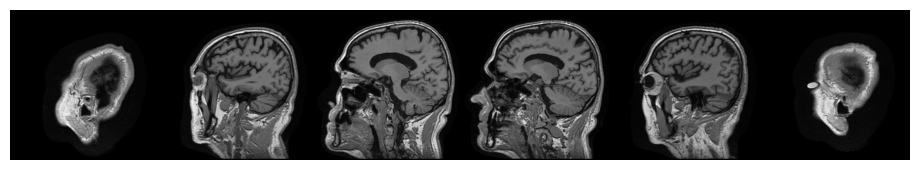

In [1]:
import sys
sys.path.append('..')

from src.data.preprocessing.pipeline import preprocess_image
import ants
import os

# Remove CUDA devices to avoid GPU usage for TF and Keras pipeline
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# Load the sample brain scan
sample_cn_path = os.path.join('../samples', 'sample_cn.nii.gz')
sample_ad_path = os.path.join('../samples', 'sample_ad.nii.gz')
img_cn = ants.image_read(sample_cn_path)

# Visualize the brain scan in different orientations
print(f"Original image shape: {img_cn.shape}")
img_cn.plot(nslices=6)

In [2]:
processed_img_cn, output_path_cn = preprocess_image(sample_cn_path)
processed_img_ad, output_path_ad = preprocess_image(sample_ad_path)

Loading image sample_cn.nii.gz
Applying bias field correction sample_cn.nii.gz
Extracting brain sample_cn.nii.gz
Registering brain to template sample_cn.nii.gz
Saving processed image sample_cn.nii.gz
Loading image sample_ad.nii.gz
Applying bias field correction sample_ad.nii.gz
Extracting brain sample_ad.nii.gz
Registering brain to template sample_ad.nii.gz
Saving processed image sample_ad.nii.gz


Processed image shape: (182, 218, 182)


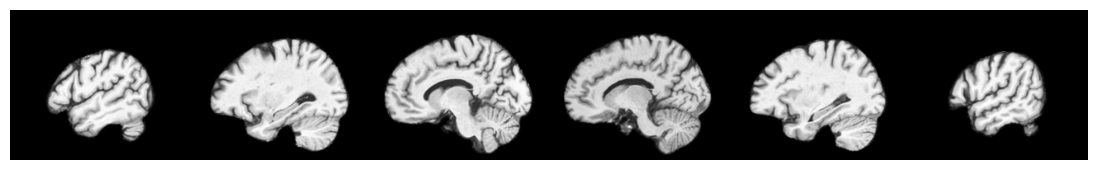

In [3]:
# Visualize the processed brain scan in different orientations
print(f"Processed image shape: {processed_img_cn.shape}")
ants.plot(processed_img_cn, nslices=6)

# Loading and Using the AutoencoderKL Model

The second step in the LDAE pipeline is to compress the preprocessed MRI scans using the AutoencoderKL model. This model compresses 3D MRI scans (1×128×160×128) to a low-dimensional latent space (3×16×20×16), enabling much more efficient processing in the latent space.

The AutoencoderKL model needs to be trained first (see `config/aekl.yaml`), or you can download pretrained weights and place them in the `models/` directory. After training or loading a pretrained AutoencoderKL, you can use it to:

1. Load the model and its weights
2. Process a MRI scan to generate its compressed latent representation 
3. Save the latents as NPZ files

The compressed latent representations are essential for:
- Training the latent diffusion model
- Enabling fast inference (20x faster than voxel-space)
- Maintaining high reconstruction fidelity (SSIM: 0.962)

Below we demonstrate loading the pretrained AutoencoderKL model and using it to compress a brain scan.

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

from generative.networks.nets import AutoencoderKL
from src.ldae.utils import load_yaml_config, get_available_device
import torch

config = load_yaml_config('../config/ldae_repr_learn.yaml')
device = get_available_device()

aekl = AutoencoderKL(**config['fit']['model']['init_args']['vae_args'])
aekl.load_state_dict(torch.load('../models/autoencoderkl.pth', map_location='cpu'))
aekl = aekl.to(device)
aekl.eval()
print("Model Successfully Loaded")

/Users/gabrielelozupone/miniconda3/envs/brain-diffae/lib/python3.11/site-packages/generative/networks/layers/vector_quantizer.py:86: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)
/Users/gabrielelozupone/miniconda3/envs/brain-diffae/lib/python3.11/site-packages/generative/networks/layers/vector_quantizer.py:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)


Model Successfully Loaded


/var/folders/np/qz5mqdbj5fl9khbxwqpf9q340000gn/T/ipykernel_15475/4207947543.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  aekl.load_state_dict(torch.load('../models/a

In [5]:
from monai.transforms import (
    LoadImaged,
    EnsureChannelFirstd,
    EnsureTyped,
    ScaleIntensityd,
    Compose,
    Spacingd,
    ResizeWithPadOrCropd,
)

image_transform = Compose([
    LoadImaged(keys=["image"], reader="NibabelReader"),
    EnsureChannelFirstd(keys=["image"]),
    EnsureTyped(keys=["image"]),
    Spacingd(pixdim=1.5, keys=['image']),
    ResizeWithPadOrCropd(spatial_size=(128, 160, 128), mode='minimum', keys=['image']),
    ScaleIntensityd(minv=0, maxv=1, keys=['image']),
])

data = [{
    "image": output_path_cn,
    "label": "CN",
    "age": 84.8,
}, {
    "image": output_path_ad,
    "label": "AD",
    "age": 66.7,
}]

inference_img = image_transform(data)

print(inference_img[0]["image"].shape)

torch.Size([1, 128, 160, 128])


In [6]:
import numpy as np

with torch.inference_mode():
    x_0 = inference_img[0]["image"] 
    # Encoding
    print("Encoding with AEKL...")
    z_0 = aekl.encode_stage_2_inputs(x_0.unsqueeze(0).to(device))
    # Decoding
    print("Decoding with AEKL...")
    x_0_hat = aekl.decode_stage_2_outputs(z_0)
    # Save the latent
    latent_path = output_path_cn.replace('.nii.gz', '_compressed_latent.npz')
    np.savez_compressed(latent_path, data=z_0.cpu().squeeze(0).numpy())

Encoding with AEKL...
Decoding with AEKL...


Mean Squared Error: 0.000549


/home/lozupone/code/LDAE/notebooks/../src/ldae/utils/visualization.py:126: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


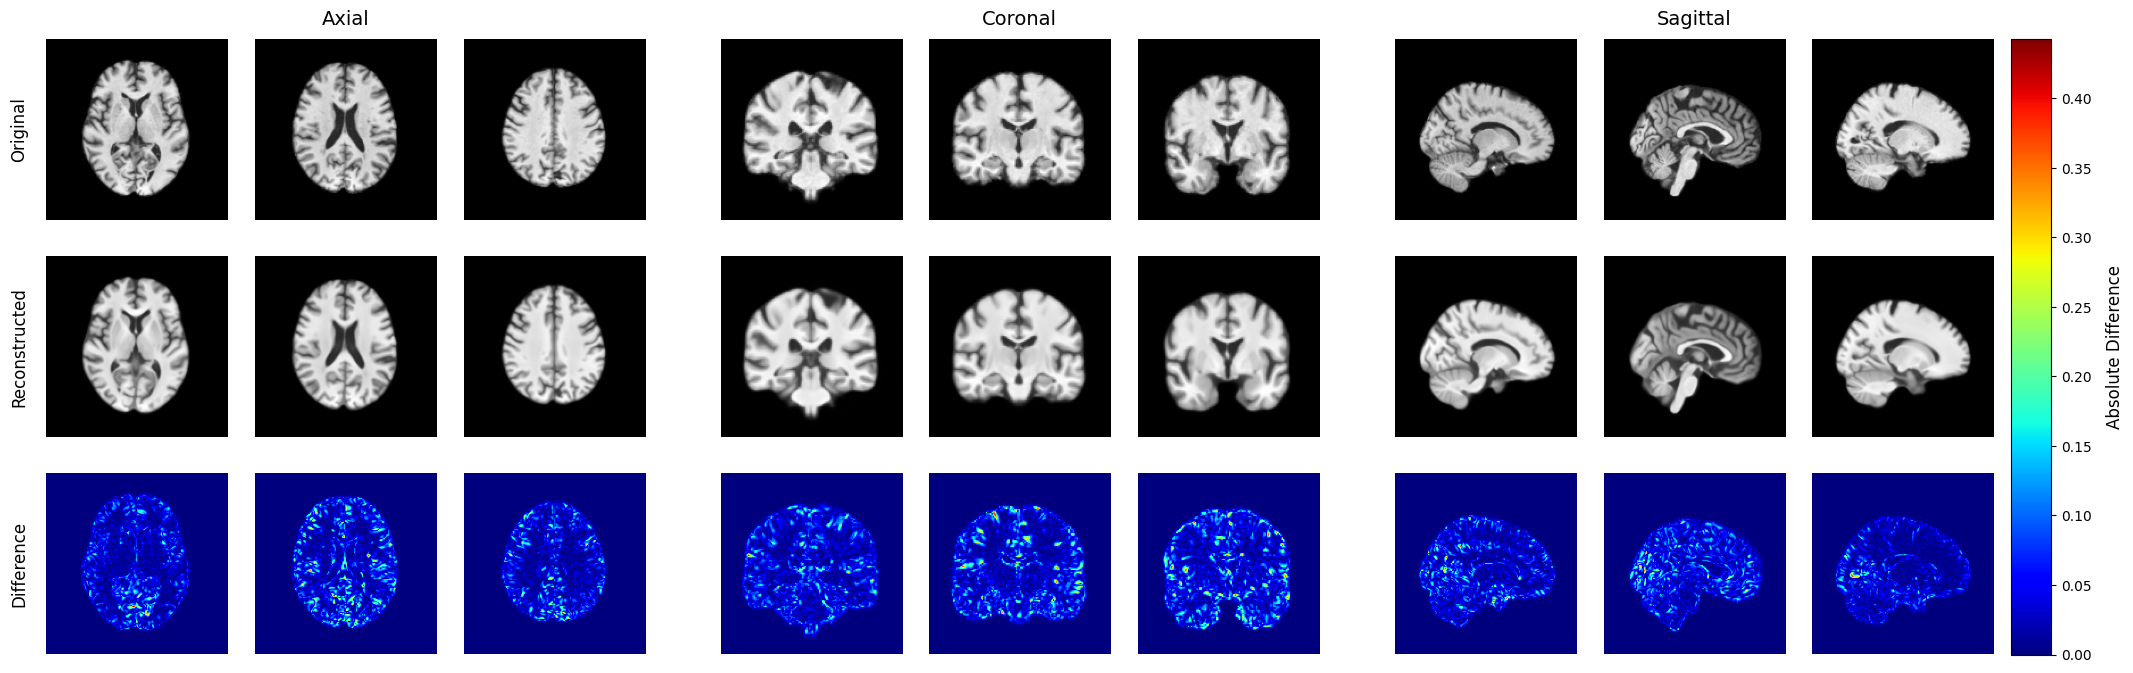

In [7]:
from src.ldae.utils.visualization import plot_difference
# Compute MSE between original and reconstructed images and plot the difference
mse = np.mean((x_0.squeeze(0).cpu().numpy() - x_0_hat.cpu().squeeze(0).squeeze(0).numpy())**2)
print(f"Mean Squared Error: {mse:.6f}")
plot_difference(x_0.squeeze(0).cpu().numpy(), x_0_hat.cpu().squeeze(0).squeeze(0).numpy(), "Original", "Reconstructed")

# LDAE: Latent Diffusion Autoencoder

Now that we've seen how the AutoencoderKL (AEKL) works for basic compression and reconstruction, let's explore the full capabilities of LDAE.

LDAE builds on top of AEKL by adding:

1. A **Semantic Encoder** (`Encϕ`) that extracts meaningful clinical features into a semantic vector `y_sem`
2. A **Latent Diffusion Model** that operates in the compressed latent space
3. A **Gradient Estimator** (`Gψ`) that guides the diffusion process using semantic information (ShiftUnet in the code)

This enables several powerful capabilities:

- **Semantic Manipulation**: We can modify brain scans along clinically meaningful directions (e.g., making a scan more AD-like or CN-like)
- **Interpolation**: Create smooth transitions between brain scans in both semantic and stochastic spaces

Let's explore each of these capabilities using our example brain scan.


In [8]:
# Let's start by loading the model
from src.ldae.nets import AttentionSemanticEncoder, ShiftUNet

enc_config = config['fit']['model']['init_args']['enc_args']
dec_config = config['fit']['model']['init_args']['unet_args']

emb_dim = enc_config['emb_chans']

encoder = AttentionSemanticEncoder(**enc_config)
decoder = ShiftUNet(latent_dim=emb_dim, **dec_config)

encoder.load_state_dict(torch.load('../models/encoder.pth', map_location="cpu"))
decoder.load_state_dict(torch.load('../models/decoder.pth', map_location='cpu'))

encoder = encoder.to(device)
decoder = decoder.to(device)

encoder.eval()
decoder.eval()
print("Encoder and Decoder loaded successfully.")

Backbone model loaded successfully.
Frozen first 0 layers out of 342 in the backbone



/tmp/ipykernel_19962/1737252850.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder.load_state_dict(torch.load('../models/encoder.pth', map_location="cpu"))
/tmp/ip

Encoder and Decoder loaded successfully.


# Let's try autoencoding with LDAE

LDAE performs autoencoding in the compressed latent space of the AutoencoderKL, guided by semantic features. The process works as follows:

1. First, we extract semantic features `y_sem` from the input image `x_0` using the Semantic Encoder
2. We encode the compressed latent `z_0` to a noisy latent `z_T` using DDIM, conditioned on `y_sem`
3. We decode `z_T` back to a clean latent `z_0_hat` using DDIM, again guided by `y_sem`
4. Finally, we decode `z_0_hat` to an image `x_0_hat` using the AutoencoderKL decoder

The key difference from regular autoencoding is that LDAE operates in the compressed latent space and uses semantic guidance during the diffusion process. This helps preserve important clinical features while allowing controlled manipulation of the latents.

Let's try this on our example brain scan:


x_0 shape: torch.Size([1, 1, 128, 128, 160])


sampling loop time step: 100%|██████████| 50/50 [00:08<00:00,  5.81it/s]


Mean Squared Error: 0.000603


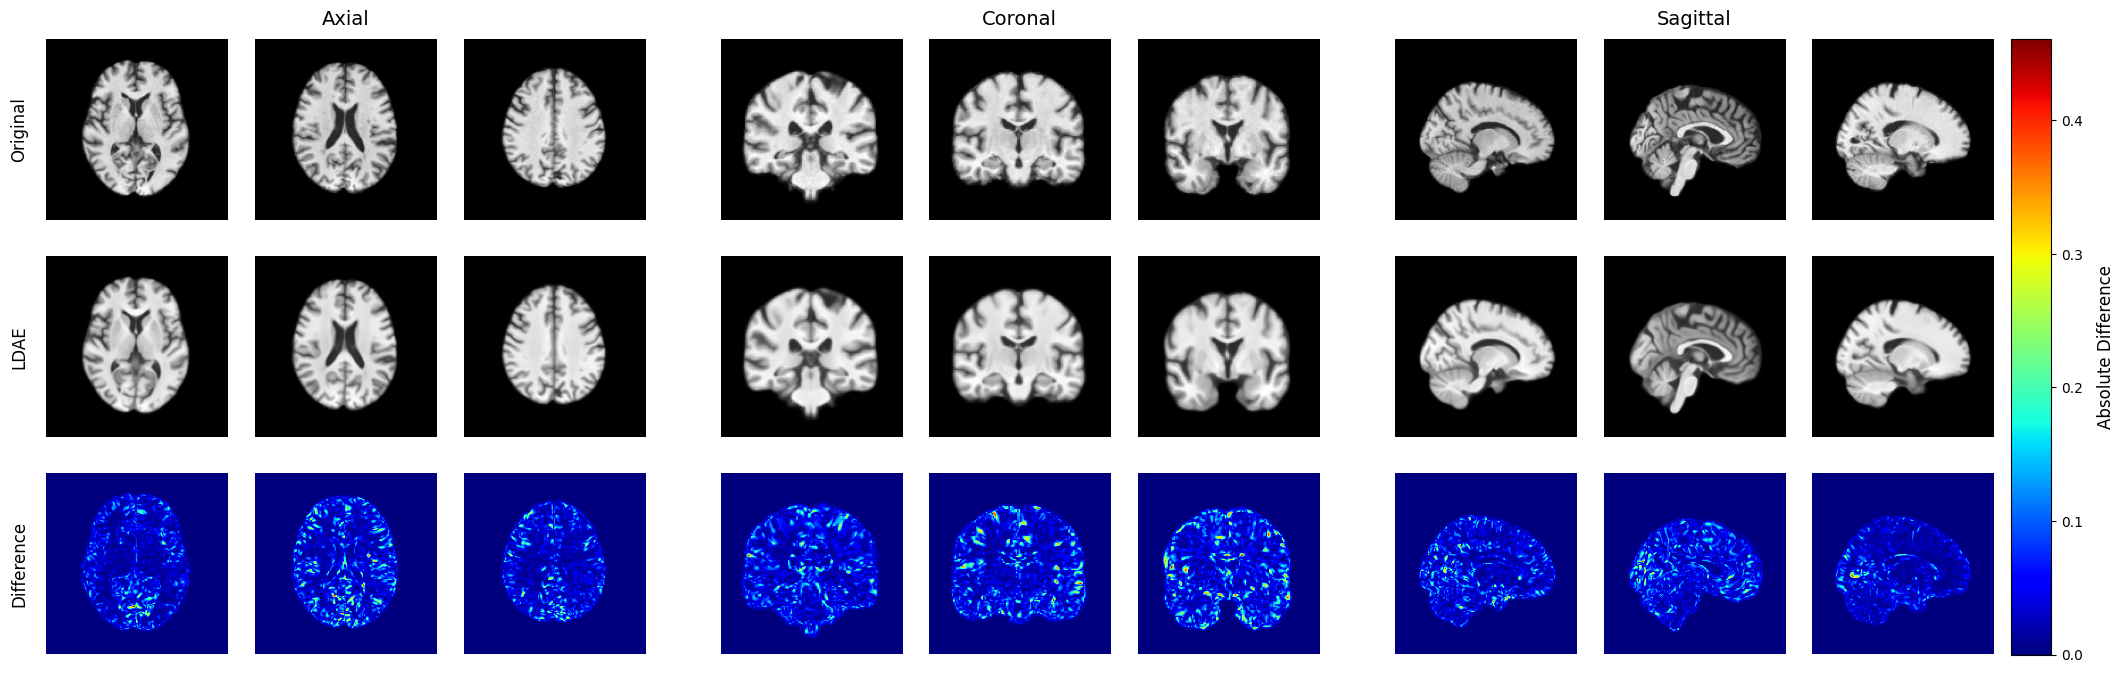

In [9]:
from src.ldae.diffusion import GaussianDiffusion
from src.data.transforms import SwapDimensionsBasedOnSlicingPlane

diffusion = GaussianDiffusion(config['fit']['model']['init_args']['timesteps_args'], device)

# The std of the first training batch for normalizatino discussed in LDM paper
scale_factor = torch.tensor(0.8730).to(device)

image_transform = Compose([
    LoadImaged(keys=["image"], reader="NibabelReader"),
    EnsureChannelFirstd(keys=["image"]),
    EnsureTyped(keys=["image"]),
    Spacingd(pixdim=1.5, keys=['image']),
    ResizeWithPadOrCropd(spatial_size=(128, 160, 128), mode='minimum', keys=['image']),
    ScaleIntensityd(minv=0, maxv=1, keys=['image']),
    SwapDimensionsBasedOnSlicingPlane(keys=["image"], slicing_plane="axial"), # Needed for Semantic 2.5D Encoder
])

encoder_input = image_transform(data)

# Perform autoencoding via LDAE
with torch.inference_mode():
    x_0 = encoder_input[0]["image"].unsqueeze(0).to(device)
    print("x_0 shape:", x_0.shape)
    z_0 = z_0 * scale_factor

    z_0_ldae = diffusion.latent_representation_learning_autoencoding(
        encoder_ddim_style='ddim50',
        decoder_ddim_style='ddim50',
        encoder=encoder,
        decoder=decoder,
        x_0=x_0,
        z_0=z_0,
        disable_tqdm=False
    )
    
    z_0_ldae = z_0_ldae / scale_factor
    x_0_ldae = aekl.decode_stage_2_outputs(z_0_ldae)

mse = np.mean((inference_img[0]["image"].squeeze(0).numpy() - x_0_ldae.cpu().squeeze(0).squeeze(0).numpy())**2)
print(f"Mean Squared Error: {mse:.6f}")
plot_difference(inference_img[0]["image"].squeeze(0).numpy(), x_0_ldae.cpu().squeeze(0).squeeze(0).numpy(), "Original", "LDAE")

# LDAE Interpolation

The **LDAE interpolation process** between two brain MRI images works as follows:

1. First, both input images are encoded into two different spaces:
   - The semantic space through the semantic encoder, producing $y_{sem_0}$ and $y_{sem_1}$
   - The compressed latent space through the AutoencoderKL, producing $z_0$ and $z_1$

2. The compressed latents $z_0$ and $z_1$ are then encoded to noise space using DDIM, guided by their respective semantic features. This produces $z_{T_0}$ and $z_{T_1}$.

3. The interpolation happens in both spaces:
   - **Linear interpolation (lerp)** is applied between the semantic features:
     $y_{sem_\alpha} = (1-\alpha)y_{sem_0} + \alpha y_{sem_1}$
   - **Spherical linear interpolation (slerp)** is applied between the noisy latents:
     $z_{T_\alpha} = \frac{\sin((1-\alpha)\omega)}{\sin(\omega)}z_{T_0} + \frac{\sin(\alpha\omega)}{\sin(\omega)}z_{T_1}$
     where $\omega = \arccos(\frac{z_{T_0} \cdot z_{T_1}}{||z_{T_0}|| \cdot ||z_{T_1}||})$
   
4. Finally, the interpolated noisy latent $z_{T_\alpha}$ and semantic features $y_{sem_\alpha}$ are used to guide the DDIM sampling process, which generates the final interpolated image.

This **dual-space interpolation** allows LDAE to create smooth and semantically meaningful transitions between brain states, preserving both structural and disease-related features.


In [10]:
# Perform interpolation via LDAE
with torch.inference_mode():
    x_0 = encoder_input[0]["image"].unsqueeze(0).to(device)
    x_1 = encoder_input[1]["image"].unsqueeze(0).to(device)
    
    x0 = inference_img[0]["image"].unsqueeze(0).to(device)
    x1 = inference_img[1]["image"].unsqueeze(0).to(device)
    
    # Extract the compressed latent
    z_0 = aekl.encode_stage_2_inputs(x0)
    z_1 = aekl.encode_stage_2_inputs(x1)
    x0 = aekl.decode_stage_2_outputs(z_0)
    x1 = aekl.decode_stage_2_outputs(z_1)
    
    z_0 = z_0 * scale_factor
    z_1 = z_1 * scale_factor

    z_0_interpolation = diffusion.latent_lerp_slerp_interpolation(
        ddim_style='ddim100',
        encoder=encoder,
        decoder=decoder,
        x_0=x_0,
        x_1=x_1,
        z_0=z_0,
        z_1=z_1,
        alpha=0.5,
        disable_tqdm=False,
    )
    
    z_0_interpolation = z_0_interpolation / scale_factor
    x_0_interpolation = aekl.decode_stage_2_outputs(z_0_interpolation)

sampling loop time step: 100%|██████████| 100/100 [00:46<00:00,  2.14it/s]


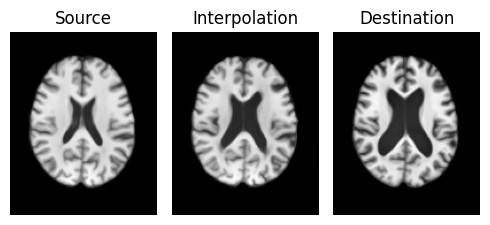

In [11]:
from matplotlib import pyplot as plt
  
# Get center slice indices for axial plane (assuming shape [B,C,H,W,D])
center_slice = x0.shape[4] // 2

# Extract center slices and move to CPU/numpy
x0_slice = x0.cpu().squeeze(0).squeeze(0)[:,:, center_slice].numpy()
x1_slice = x1.cpu().squeeze(0).squeeze(0)[:,:, center_slice].numpy()
interp_slice = x_0_interpolation.cpu().squeeze(0).squeeze(0)[:,:, center_slice].numpy()

# Create figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(5,3))

# Plot slices
axes[0].imshow(np.rot90(x0_slice), cmap='gray')
axes[0].set_title('Source')
axes[0].axis('off')

axes[1].imshow(np.rot90(interp_slice), cmap='gray') 
axes[1].set_title('Interpolation')
axes[1].axis('off')

axes[2].imshow(np.rot90(x1_slice), cmap='gray')
axes[2].set_title('Destination')
axes[2].axis('off')

plt.tight_layout()
plt.show()

# Semantic Manipulation

In this section, we demonstrate how to perform semantic manipulation using LDAE. The idea is to modify the semantic representation of an image by adding a direction vector in the semantic space, guided by a trained classifier.

The process works as follows:

1. We first load a trained linear classifier that predicts disease status (CN vs AD) from the semantic embeddings
2. The weights of this classifier define a direction in semantic space that points towards "CN-like" features
3. We extract the semantic embedding of our input image and normalize it using pre-computed statistics
4. We add the scaled classifier direction to the normalized semantic embedding
5. The modified semantic embedding is then used to guide the DDIM sampling process

The key parameters are:
- `direction`: The classifier weights defining the manipulation direction
- `scale`: Controls the strength of the manipulation (higher values = stronger effect)
- `mean/std`: Used to normalize the semantic space before manipulation

This allows us to "push" the image features towards being more CN-like or AD-like in a controlled way, while preserving the overall image structure through the diffusion process.


In [13]:
from torch import nn

disease_classifier = nn.Linear(emb_dim, 1)
disease_classifier.load_state_dict(torch.load('../models/disease_classifier.ckpt', map_location='cpu'))
disease_classifier = disease_classifier.to(device)
disease_classifier.eval()

cn_direction = disease_classifier.weight.to(device)

semantic_mean = torch.load('../models/semantic_mean.pt', map_location=device)
semantic_std = torch.load('../models/semantic_std.pt', map_location=device)

# Perform interpolation via LDAE
with torch.inference_mode():
    x_0 = encoder_input[1]["image"].unsqueeze(0).to(device)
    x0 = inference_img[1]["image"].unsqueeze(0).to(device)
    
    # Extract the compressed latent
    z_0 = aekl.encode_stage_2_inputs(x0)
    x0 = aekl.decode_stage_2_outputs(z_0)
    
    z_0 = z_0 * scale_factor

    z_0_manipulated = diffusion.latent_semantic_manipulation(
        ddim_style='ddim100',
        encoder=encoder,
        decoder=decoder,
        x_0=x_0,
        z_0=z_0,
        direction=cn_direction,
        mean=semantic_mean,
        std=semantic_std,
        scale=2.5,
        disable_tqdm=False,
    )
    
    z_0_manipulated = z_0_manipulated / scale_factor
    x_0_manipulated = aekl.decode_stage_2_outputs(z_0_manipulated)

sampling loop time step: 100%|██████████| 100/100 [00:17<00:00,  5.79it/s]


/home/lozupone/code/LDAE/notebooks/../src/ldae/utils/visualization.py:126: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


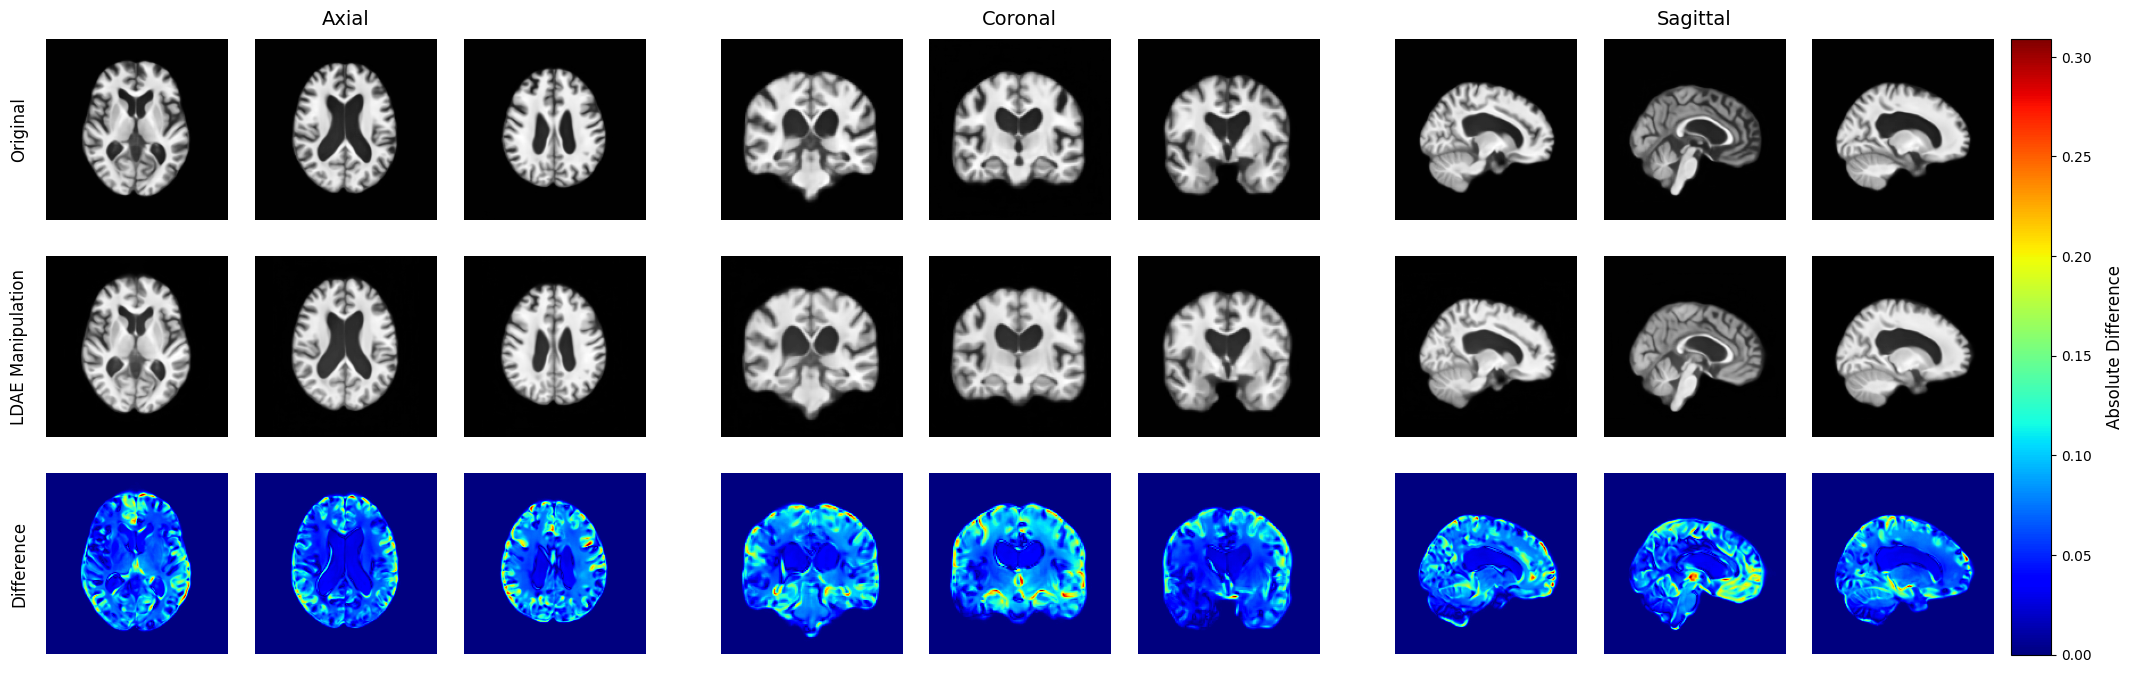

In [14]:
plot_difference(x0.cpu().squeeze(0).squeeze(0).numpy(), x_0_manipulated.cpu().squeeze(0).squeeze(0).numpy(), "Original", "LDAE Manipulation")